In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
from torchvision import models
from torchvision.models import MobileNet_V2_Weights
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
# Kiểm tra có GPU hay không
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(torch.cuda.device_count())  # Trả về số lượng GPU

Using device: cuda
1


In [3]:
# Định nghĩa đường dẫn thư mục dữ liệu
train_dir = '/kaggle/input/data-alphabet/letters_data/train'
validation_dir = '/kaggle/input/data-alphabet/letters_data/val'
test_dir = '/kaggle/input/data-alphabet/letters_data/test'

In [4]:
# Image size phù hợp với MobileNetV2
IMAGE_SIZE = 224

# Tiền xử lý dữ liệu
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Chuẩn hóa giống ImageNet
])

In [5]:
# Load dataset
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(validation_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

In [6]:
# Số lượng lớp
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

# DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Number of classes: 26


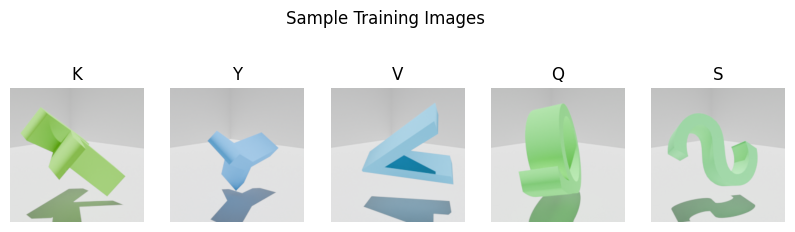

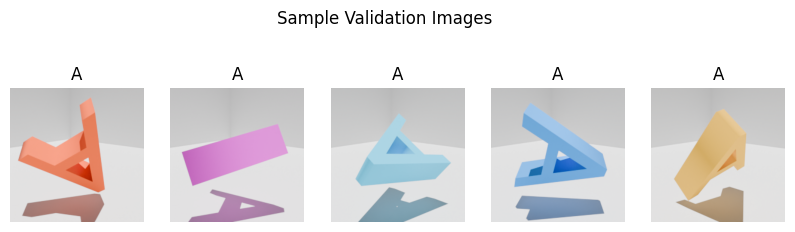

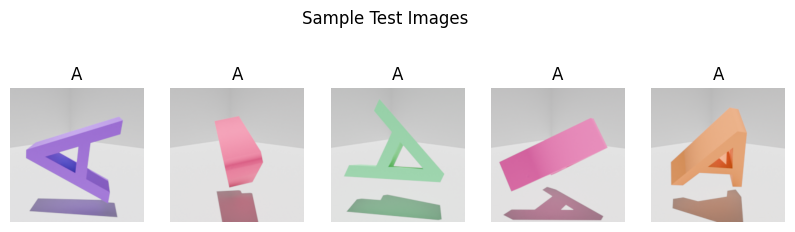

In [7]:
# Hàm khử chuẩn hóa ảnh trước khi hiển thị
def denormalize_image(tensor, mean, std):
    mean = np.array(mean).reshape(1, 1, 3)
    std = np.array(std).reshape(1, 1, 3)

    # Chuyển từ Tensor sang NumPy
    image = tensor.numpy().transpose((1, 2, 0))  # Chuyển đổi từ (C, H, W) → (H, W, C)

    # Khử chuẩn hóa
    image = (image * std) + mean

    # Đảm bảo giá trị nằm trong khoảng [0,1] để hiển thị đúng
    return np.clip(image, 0, 1)

# Cập nhật lại hàm hiển thị mẫu
def display_samples(data_loader, title, classes):
    mean = [0.485, 0.456, 0.406]  # Mean của ImageNet
    std = [0.229, 0.224, 0.225]   # Std của ImageNet

    images, labels = next(iter(data_loader))

    fig, axes = plt.subplots(1, 5, figsize=(10, 3))
    for i in range(5):
        image = denormalize_image(images[i], mean, std)
        axes[i].imshow(image)
        axes[i].set_title(classes[labels[i].item()])
        axes[i].axis('off')

    plt.suptitle(title)
    plt.show()

# Gọi lại hàm hiển thị
display_samples(train_loader, 'Sample Training Images', train_dataset.classes)
display_samples(val_loader, 'Sample Validation Images', val_dataset.classes)
display_samples(test_loader, 'Sample Test Images', test_dataset.classes)


In [8]:
# Load mô hình với trọng số ImageNet mặc định
model = models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)

# Đóng băng toàn bộ các layer gốc
for param in model.features.parameters():
    param.requires_grad = False

# Thay thế fully connected layer để phù hợp với số lớp
model.classifier[1] = nn.Linear(model.last_channel, num_classes)
model = model.to(device)

# Hiển thị kiến trúc model
print(model)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 183MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=


Starting Training...


[Epoch 1/35]


Training Epoch 1/35: 100%|██████████| 122/122 [00:28<00:00,  4.30batch/s, loss=2.4] 


Epoch Time: 28.40s
Train Loss: 2.7028, Train Acc: 0.2638


Validating Epoch 1/35: 100%|██████████| 33/33 [00:07<00:00,  4.49batch/s, loss=2.71]


Val Loss: 2.2922, Val Acc: 0.4231

[Epoch 2/35]


Training Epoch 2/35: 100%|██████████| 122/122 [00:19<00:00,  6.17batch/s, loss=1.87]


Epoch Time: 19.79s
Train Loss: 2.0680, Train Acc: 0.4856


Validating Epoch 2/35: 100%|██████████| 33/33 [00:05<00:00,  5.67batch/s, loss=2.29]


Val Loss: 1.9549, Val Acc: 0.4798

[Epoch 3/35]


Training Epoch 3/35: 100%|██████████| 122/122 [00:22<00:00,  5.41batch/s, loss=1.67]


Epoch Time: 22.58s
Train Loss: 1.7714, Train Acc: 0.5653


Validating Epoch 3/35: 100%|██████████| 33/33 [00:06<00:00,  4.95batch/s, loss=1.98] 


Val Loss: 1.7716, Val Acc: 0.5173

[Epoch 4/35]


Training Epoch 4/35: 100%|██████████| 122/122 [00:23<00:00,  5.21batch/s, loss=1.53]


Epoch Time: 23.41s
Train Loss: 1.5896, Train Acc: 0.6049


Validating Epoch 4/35: 100%|██████████| 33/33 [00:06<00:00,  5.11batch/s, loss=1.78] 


Val Loss: 1.6481, Val Acc: 0.5500

[Epoch 5/35]


Training Epoch 5/35: 100%|██████████| 122/122 [00:22<00:00,  5.31batch/s, loss=1.32]


Epoch Time: 22.98s
Train Loss: 1.4684, Train Acc: 0.6238


Validating Epoch 5/35: 100%|██████████| 33/33 [00:05<00:00,  5.81batch/s, loss=2.13] 


Val Loss: 1.5527, Val Acc: 0.5702

[Epoch 6/35]


Training Epoch 6/35: 100%|██████████| 122/122 [00:19<00:00,  6.20batch/s, loss=1.26]


Epoch Time: 19.67s
Train Loss: 1.3647, Train Acc: 0.6444


Validating Epoch 6/35: 100%|██████████| 33/33 [00:04<00:00,  6.75batch/s, loss=1.93] 


Val Loss: 1.4928, Val Acc: 0.5769

[Epoch 7/35]


Training Epoch 7/35: 100%|██████████| 122/122 [00:20<00:00,  5.93batch/s, loss=1.38]


Epoch Time: 20.59s
Train Loss: 1.2817, Train Acc: 0.6651


Validating Epoch 7/35: 100%|██████████| 33/33 [00:05<00:00,  6.50batch/s, loss=1.73] 


Val Loss: 1.4383, Val Acc: 0.5971

[Epoch 8/35]


Training Epoch 8/35: 100%|██████████| 122/122 [00:29<00:00,  4.07batch/s, loss=1.3]  


Epoch Time: 30.01s
Train Loss: 1.2280, Train Acc: 0.6747


Validating Epoch 8/35: 100%|██████████| 33/33 [00:08<00:00,  3.89batch/s, loss=1.88] 


Val Loss: 1.3991, Val Acc: 0.5918

[Epoch 9/35]


Training Epoch 9/35: 100%|██████████| 122/122 [00:26<00:00,  4.52batch/s, loss=1.01] 


Epoch Time: 26.97s
Train Loss: 1.1661, Train Acc: 0.6928


Validating Epoch 9/35: 100%|██████████| 33/33 [00:06<00:00,  4.98batch/s, loss=1.31] 


Val Loss: 1.3707, Val Acc: 0.5971

[Epoch 10/35]


Training Epoch 10/35: 100%|██████████| 122/122 [00:18<00:00,  6.59batch/s, loss=1.29] 


Epoch Time: 18.52s
Train Loss: 1.1314, Train Acc: 0.6946


Validating Epoch 10/35: 100%|██████████| 33/33 [00:06<00:00,  5.20batch/s, loss=1.99] 


Val Loss: 1.3388, Val Acc: 0.5990

[Epoch 11/35]


Training Epoch 11/35: 100%|██████████| 122/122 [00:18<00:00,  6.61batch/s, loss=1.1]  


Epoch Time: 18.47s
Train Loss: 1.0809, Train Acc: 0.7092


Validating Epoch 11/35: 100%|██████████| 33/33 [00:05<00:00,  6.43batch/s, loss=1.72] 


Val Loss: 1.3061, Val Acc: 0.6159

[Epoch 12/35]


Training Epoch 12/35: 100%|██████████| 122/122 [00:18<00:00,  6.57batch/s, loss=1.39] 


Epoch Time: 18.57s
Train Loss: 1.0548, Train Acc: 0.7168


Validating Epoch 12/35: 100%|██████████| 33/33 [00:05<00:00,  6.50batch/s, loss=2.04] 


Val Loss: 1.2931, Val Acc: 0.6149

[Epoch 13/35]


Training Epoch 13/35: 100%|██████████| 122/122 [00:18<00:00,  6.71batch/s, loss=0.923]


Epoch Time: 18.20s
Train Loss: 1.0301, Train Acc: 0.7128


Validating Epoch 13/35: 100%|██████████| 33/33 [00:04<00:00,  6.63batch/s, loss=1.57] 


Val Loss: 1.2743, Val Acc: 0.6106

[Epoch 14/35]


Training Epoch 14/35: 100%|██████████| 122/122 [00:18<00:00,  6.61batch/s, loss=1.16] 


Epoch Time: 18.48s
Train Loss: 0.9957, Train Acc: 0.7212


Validating Epoch 14/35: 100%|██████████| 33/33 [00:04<00:00,  6.79batch/s, loss=1.67] 


Val Loss: 1.2589, Val Acc: 0.6197

[Epoch 15/35]


Training Epoch 15/35: 100%|██████████| 122/122 [00:18<00:00,  6.77batch/s, loss=0.806]


Epoch Time: 18.04s
Train Loss: 0.9645, Train Acc: 0.7372


Validating Epoch 15/35: 100%|██████████| 33/33 [00:04<00:00,  6.60batch/s, loss=1.66] 


Val Loss: 1.2536, Val Acc: 0.6188

[Epoch 16/35]


Training Epoch 16/35: 100%|██████████| 122/122 [00:18<00:00,  6.69batch/s, loss=0.949]


Epoch Time: 18.24s
Train Loss: 0.9441, Train Acc: 0.7431


Validating Epoch 16/35: 100%|██████████| 33/33 [00:05<00:00,  6.57batch/s, loss=1.76] 


Val Loss: 1.2507, Val Acc: 0.6139

[Epoch 17/35]


Training Epoch 17/35: 100%|██████████| 122/122 [00:18<00:00,  6.72batch/s, loss=0.785]


Epoch Time: 18.18s
Train Loss: 0.9251, Train Acc: 0.7472


Validating Epoch 17/35: 100%|██████████| 33/33 [00:04<00:00,  6.92batch/s, loss=1.69] 


Val Loss: 1.2234, Val Acc: 0.6308

[Epoch 18/35]


Training Epoch 18/35: 100%|██████████| 122/122 [00:18<00:00,  6.61batch/s, loss=1.13] 


Epoch Time: 18.47s
Train Loss: 0.9060, Train Acc: 0.7523


Validating Epoch 18/35: 100%|██████████| 33/33 [00:04<00:00,  6.64batch/s, loss=1.58] 


Val Loss: 1.2240, Val Acc: 0.6231

[Epoch 19/35]


Training Epoch 19/35: 100%|██████████| 122/122 [00:17<00:00,  6.78batch/s, loss=0.852]


Epoch Time: 17.99s
Train Loss: 0.8870, Train Acc: 0.7518


Validating Epoch 19/35: 100%|██████████| 33/33 [00:05<00:00,  6.56batch/s, loss=1.49] 


Val Loss: 1.2116, Val Acc: 0.6346

[Epoch 20/35]


Training Epoch 20/35: 100%|██████████| 122/122 [00:17<00:00,  6.80batch/s, loss=0.857]


Epoch Time: 17.96s
Train Loss: 0.8793, Train Acc: 0.7521


Validating Epoch 20/35: 100%|██████████| 33/33 [00:04<00:00,  6.64batch/s, loss=1.65] 


Val Loss: 1.1919, Val Acc: 0.6293

[Epoch 21/35]


Training Epoch 21/35: 100%|██████████| 122/122 [00:18<00:00,  6.64batch/s, loss=1.03] 


Epoch Time: 18.39s
Train Loss: 0.8688, Train Acc: 0.7572


Validating Epoch 21/35: 100%|██████████| 33/33 [00:05<00:00,  6.59batch/s, loss=1.55] 


Val Loss: 1.1947, Val Acc: 0.6322

[Epoch 22/35]


Training Epoch 22/35: 100%|██████████| 122/122 [00:18<00:00,  6.51batch/s, loss=0.913]


Epoch Time: 18.76s
Train Loss: 0.8538, Train Acc: 0.7537


Validating Epoch 22/35: 100%|██████████| 33/33 [00:04<00:00,  6.71batch/s, loss=1.75] 


Val Loss: 1.1877, Val Acc: 0.6337

[Epoch 23/35]


Training Epoch 23/35: 100%|██████████| 122/122 [00:29<00:00,  4.16batch/s, loss=0.854]


Epoch Time: 29.36s
Train Loss: 0.8218, Train Acc: 0.7696


Validating Epoch 23/35: 100%|██████████| 33/33 [00:11<00:00,  2.76batch/s, loss=1.65] 


Val Loss: 1.1934, Val Acc: 0.6221

[Epoch 24/35]


Training Epoch 24/35: 100%|██████████| 122/122 [00:20<00:00,  5.88batch/s, loss=0.801]


Epoch Time: 20.75s
Train Loss: 0.8187, Train Acc: 0.7638


Validating Epoch 24/35: 100%|██████████| 33/33 [00:04<00:00,  7.13batch/s, loss=1.67] 


Val Loss: 1.1832, Val Acc: 0.6322

[Epoch 25/35]


Training Epoch 25/35: 100%|██████████| 122/122 [00:19<00:00,  6.40batch/s, loss=0.923]


Epoch Time: 19.06s
Train Loss: 0.8089, Train Acc: 0.7646


Validating Epoch 25/35: 100%|██████████| 33/33 [00:05<00:00,  5.79batch/s, loss=1.54] 


Val Loss: 1.1761, Val Acc: 0.6274

[Epoch 26/35]


Training Epoch 26/35: 100%|██████████| 122/122 [00:19<00:00,  6.20batch/s, loss=0.576]


Epoch Time: 19.67s
Train Loss: 0.7975, Train Acc: 0.7685


Validating Epoch 26/35: 100%|██████████| 33/33 [00:04<00:00,  6.65batch/s, loss=1.43] 


Val Loss: 1.1654, Val Acc: 0.6298

[Epoch 27/35]


Training Epoch 27/35: 100%|██████████| 122/122 [00:18<00:00,  6.65batch/s, loss=0.791]


Epoch Time: 18.36s
Train Loss: 0.7871, Train Acc: 0.7712


Validating Epoch 27/35: 100%|██████████| 33/33 [00:05<00:00,  5.67batch/s, loss=1.67] 


Val Loss: 1.1693, Val Acc: 0.6399

[Epoch 28/35]


Training Epoch 28/35: 100%|██████████| 122/122 [00:27<00:00,  4.49batch/s, loss=0.898]


Epoch Time: 27.18s
Train Loss: 0.7797, Train Acc: 0.7733


Validating Epoch 28/35: 100%|██████████| 33/33 [00:06<00:00,  4.95batch/s, loss=1.56] 


Val Loss: 1.1652, Val Acc: 0.6346

[Epoch 29/35]


Training Epoch 29/35: 100%|██████████| 122/122 [00:27<00:00,  4.38batch/s, loss=0.763]


Epoch Time: 27.86s
Train Loss: 0.7597, Train Acc: 0.7814


Validating Epoch 29/35: 100%|██████████| 33/33 [00:07<00:00,  4.29batch/s, loss=1.56] 


Val Loss: 1.1544, Val Acc: 0.6389

[Epoch 30/35]


Training Epoch 30/35: 100%|██████████| 122/122 [00:25<00:00,  4.77batch/s, loss=0.821]


Epoch Time: 25.59s
Train Loss: 0.7560, Train Acc: 0.7799


Validating Epoch 30/35: 100%|██████████| 33/33 [00:05<00:00,  6.37batch/s, loss=1.48] 


Val Loss: 1.1456, Val Acc: 0.6418

[Epoch 31/35]


Training Epoch 31/35: 100%|██████████| 122/122 [00:19<00:00,  6.19batch/s, loss=0.725]


Epoch Time: 19.72s
Train Loss: 0.7532, Train Acc: 0.7818


Validating Epoch 31/35: 100%|██████████| 33/33 [00:05<00:00,  5.53batch/s, loss=1.51] 


Val Loss: 1.1547, Val Acc: 0.6351

[Epoch 32/35]


Training Epoch 32/35: 100%|██████████| 122/122 [00:21<00:00,  5.58batch/s, loss=0.626]


Epoch Time: 21.89s
Train Loss: 0.7616, Train Acc: 0.7701


Validating Epoch 32/35: 100%|██████████| 33/33 [00:05<00:00,  5.61batch/s, loss=1.68] 


Val Loss: 1.1476, Val Acc: 0.6337

[Epoch 33/35]


Training Epoch 33/35: 100%|██████████| 122/122 [00:24<00:00,  5.07batch/s, loss=0.801]


Epoch Time: 24.08s
Train Loss: 0.7357, Train Acc: 0.7871


Validating Epoch 33/35: 100%|██████████| 33/33 [00:07<00:00,  4.68batch/s, loss=1.45] 


Val Loss: 1.1488, Val Acc: 0.6317

[Epoch 34/35]


Training Epoch 34/35: 100%|██████████| 122/122 [00:24<00:00,  5.00batch/s, loss=0.699]


Epoch Time: 24.43s
Train Loss: 0.7278, Train Acc: 0.7851


Validating Epoch 34/35: 100%|██████████| 33/33 [00:07<00:00,  4.15batch/s, loss=1.53] 


Val Loss: 1.1510, Val Acc: 0.6380

[Epoch 35/35]


Training Epoch 35/35: 100%|██████████| 122/122 [00:32<00:00,  3.74batch/s, loss=0.727]


Epoch Time: 32.59s
Train Loss: 0.7216, Train Acc: 0.7865


Validating Epoch 35/35: 100%|██████████| 33/33 [00:10<00:00,  3.15batch/s, loss=1.51] 


Val Loss: 1.1456, Val Acc: 0.6332

Training Complete!
Model saved as mobilenetv2_finetuned.pth




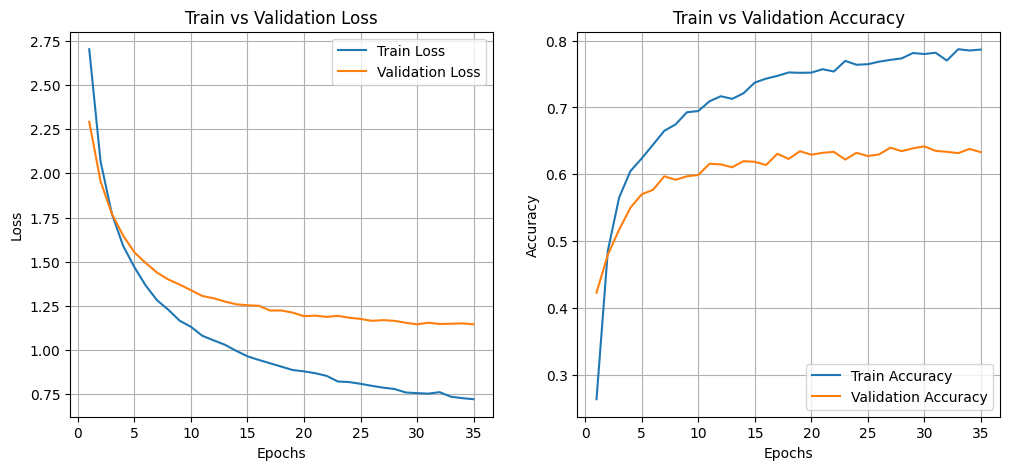


Generating Confusion Matrix...


Computing Confusion Matrix: 100%|██████████| 33/33 [00:09<00:00,  3.66batch/s]


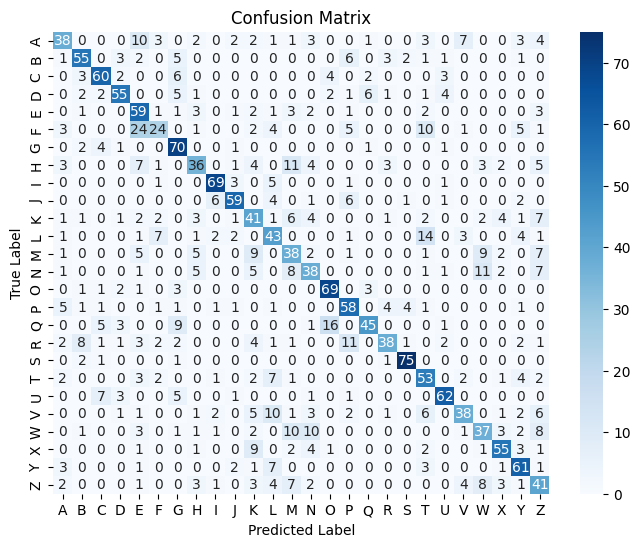


Classification Report:
              precision    recall  f1-score   support

           A       0.60      0.47      0.53        80
           B       0.71      0.69      0.70        80
           C       0.73      0.75      0.74        80
           D       0.76      0.69      0.72        80
           E       0.47      0.74      0.58        80
           F       0.55      0.30      0.39        80
           G       0.64      0.88      0.74        80
           H       0.57      0.45      0.50        80
           I       0.83      0.86      0.85        80
           J       0.80      0.74      0.77        80
           K       0.45      0.51      0.48        80
           L       0.48      0.54      0.51        80
           M       0.43      0.47      0.45        80
           N       0.51      0.47      0.49        80
           O       0.75      0.86      0.80        80
           P       0.62      0.72      0.67        80
           Q       0.78      0.56      0.65        80
   

In [9]:
# Loss function và Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Training loop
epochs = 35
train_steps = len(train_loader)
val_steps = len(val_loader)

# Danh sách lưu loss và accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print("\nStarting Training...\n")

for epoch in range(epochs):
    print("================================")
    print(f"\n[Epoch {epoch+1}/{epochs}]")

    # Training phase
    model.train()
    running_loss, running_corrects = 0.0, 0

    train_progress = tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}", unit="batch")
    
    start_time = time.time()  # Ghi lại thời gian bắt đầu

    for images, labels in train_progress:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

        # Cập nhật hiển thị tiến trình
        train_progress.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_dataset)
    train_acc = running_corrects.double() / len(train_dataset)
    epoch_time = time.time() - start_time  # Thời gian train một epoch

    train_losses.append(train_loss)
    train_accuracies.append(train_acc.item())

    print(f"Epoch Time: {epoch_time:.2f}s")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    # Validation phase
    model.eval()
    val_loss, val_corrects = 0.0, 0

    val_progress = tqdm(val_loader, desc=f"Validating Epoch {epoch+1}/{epochs}", unit="batch")

    with torch.no_grad():
        for images, labels in val_progress:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)

            # Cập nhật hiển thị tiến trình
            val_progress.set_postfix(loss=loss.item())

    val_loss = val_loss / len(val_dataset)
    val_acc = val_corrects.double() / len(val_dataset)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())

    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

print("\nTraining Complete!")

# Lưu model
torch.save(model.state_dict(), "mobilenetv2_finetuned.pth")
print("Model saved as mobilenetv2_finetuned.pth\n\n")

# Vẽ đồ thị Loss và Accuracy
plt.figure(figsize=(12, 5))

# Vẽ Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid()

# Vẽ Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid()

plt.show()

# ==========================
# Thêm Confusion Matrix
# ==========================

print("\nGenerating Confusion Matrix...")

# Thu thập tất cả nhãn thực và nhãn dự đoán từ tập validation
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Computing Confusion Matrix", unit="batch"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Tạo Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
class_names = val_dataset.classes  # Lấy tên các lớp từ dataset

# Hiển thị Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# In báo cáo phân loại chi tiết
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))



Evaluating on Test Set...


Testing: 100%|██████████| 4/4 [00:00<00:00,  4.54batch/s, loss=1.43] 



Test Loss: 1.1415, Test Acc: 0.6875

Generating Confusion Matrix for Test Set...


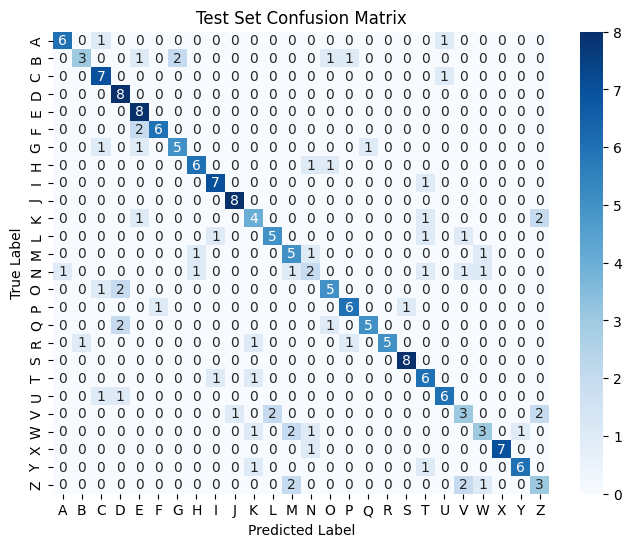


Test Set Classification Report:
              precision    recall  f1-score   support

           A       0.86      0.75      0.80         8
           B       0.75      0.38      0.50         8
           C       0.64      0.88      0.74         8
           D       0.62      1.00      0.76         8
           E       0.62      1.00      0.76         8
           F       0.86      0.75      0.80         8
           G       0.71      0.62      0.67         8
           H       0.75      0.75      0.75         8
           I       0.78      0.88      0.82         8
           J       0.89      1.00      0.94         8
           K       0.50      0.50      0.50         8
           L       0.71      0.62      0.67         8
           M       0.50      0.62      0.56         8
           N       0.33      0.25      0.29         8
           O       0.62      0.62      0.62         8
           P       0.75      0.75      0.75         8
           Q       0.83      0.62      0.71     

In [10]:
# Load lại model để kiểm tra
model.load_state_dict(torch.load("mobilenetv2_finetuned.pth", weights_only=True))
model.eval()

# Kiểm tra trên tập test
test_corrects = 0
test_loss = 0.0
all_test_preds = []
all_test_labels = []

print("\nEvaluating on Test Set...")
test_progress = tqdm(test_loader, desc="Testing", unit="batch")

with torch.no_grad():
    for images, labels in test_progress:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)

        # Lưu kết quả dự đoán để vẽ Confusion Matrix
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

        # Cập nhật hiển thị tiến trình
        test_progress.set_postfix(loss=loss.item())

test_loss = test_loss / len(test_dataset)
test_acc = test_corrects.double() / len(test_dataset)

print(f"\nTest Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

# ==========================
# Thêm Confusion Matrix cho tập test
# ==========================

print("\nGenerating Confusion Matrix for Test Set...")

# Tạo Confusion Matrix
test_conf_matrix = confusion_matrix(all_test_labels, all_test_preds)
class_names = test_dataset.classes  # Lấy tên các lớp từ dataset

# Hiển thị Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Test Set Confusion Matrix")
plt.show()

# In báo cáo phân loại chi tiết
print("\nTest Set Classification Report:")
print(classification_report(all_test_labels, all_test_preds, target_names=class_names))


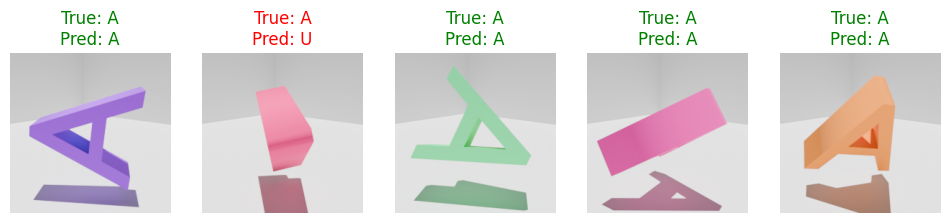

In [11]:
# Hàm hiển thị ảnh và kết quả dự đoán
def display_predictions(model, data_loader, classes, num_images=5):
    model.eval()  # Chuyển mô hình sang chế độ đánh giá
    mean = [0.485, 0.456, 0.406]  # Mean của ImageNet
    std = [0.229, 0.224, 0.225]   # Std của ImageNet

    images, labels = next(iter(data_loader))  # Lấy một batch ảnh
    images, labels = images[:num_images], labels[:num_images]  # Chỉ lấy số lượng ảnh cần hiển thị

    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Lấy class dự đoán

    images = images.cpu()  # Chuyển về CPU để hiển thị
    labels = labels.cpu()
    preds = preds.cpu()

    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))

    for i in range(num_images):
        image = denormalize_image(images[i], mean, std)  # Khử chuẩn hóa
        axes[i].imshow(image)
        true_label = classes[labels[i].item()]
        pred_label = classes[preds[i].item()]
        color = "green" if true_label == pred_label else "red"
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}", color=color)
        axes[i].axis('off')

    plt.show()

# Gọi hàm để hiển thị ảnh với dự đoán
display_predictions(model, test_loader, test_dataset.classes, num_images=5)